[INFO] 坐标与 CIR 归一化参数已保存到 ./stats/

✅ 找到有效近邻，距离: 0.25米

📡 最接近坐标的真实 CIR:
 tensor([[206.8726,  77.5000,   2.5631],
        [182.9318,  63.7800,  -2.8177],
        [208.4267,  57.7100,   2.6575],
        [213.1657,  55.8000,  -0.2766],
        [183.4077,  55.6900,  -2.8148],
        [183.4077,  55.6900,  -2.8148],
        [202.3852,  47.3000,  -2.6222],
        [183.5381,  43.9600,  -2.8146],
        [183.5381,  43.9600,  -2.8146],
        [208.7311,  43.7300,   2.5623],
        [208.7311,  43.7300,   2.5623],
        [188.2072,  43.4400,  -2.8812],
        [188.2072,  43.4400,  -2.8812],
        [185.5134,  43.3500,  -2.7435],
        [183.4400,  43.0700,  -2.8100],
        [183.4400,  43.0700,  -2.8100],
        [184.2290,  40.3800,  -2.8400],
        [184.2290,  40.3800,  -2.8400],
        [194.2928,  40.2900,  -3.0539],
        [194.2928,  40.2900,  -3.0539]])


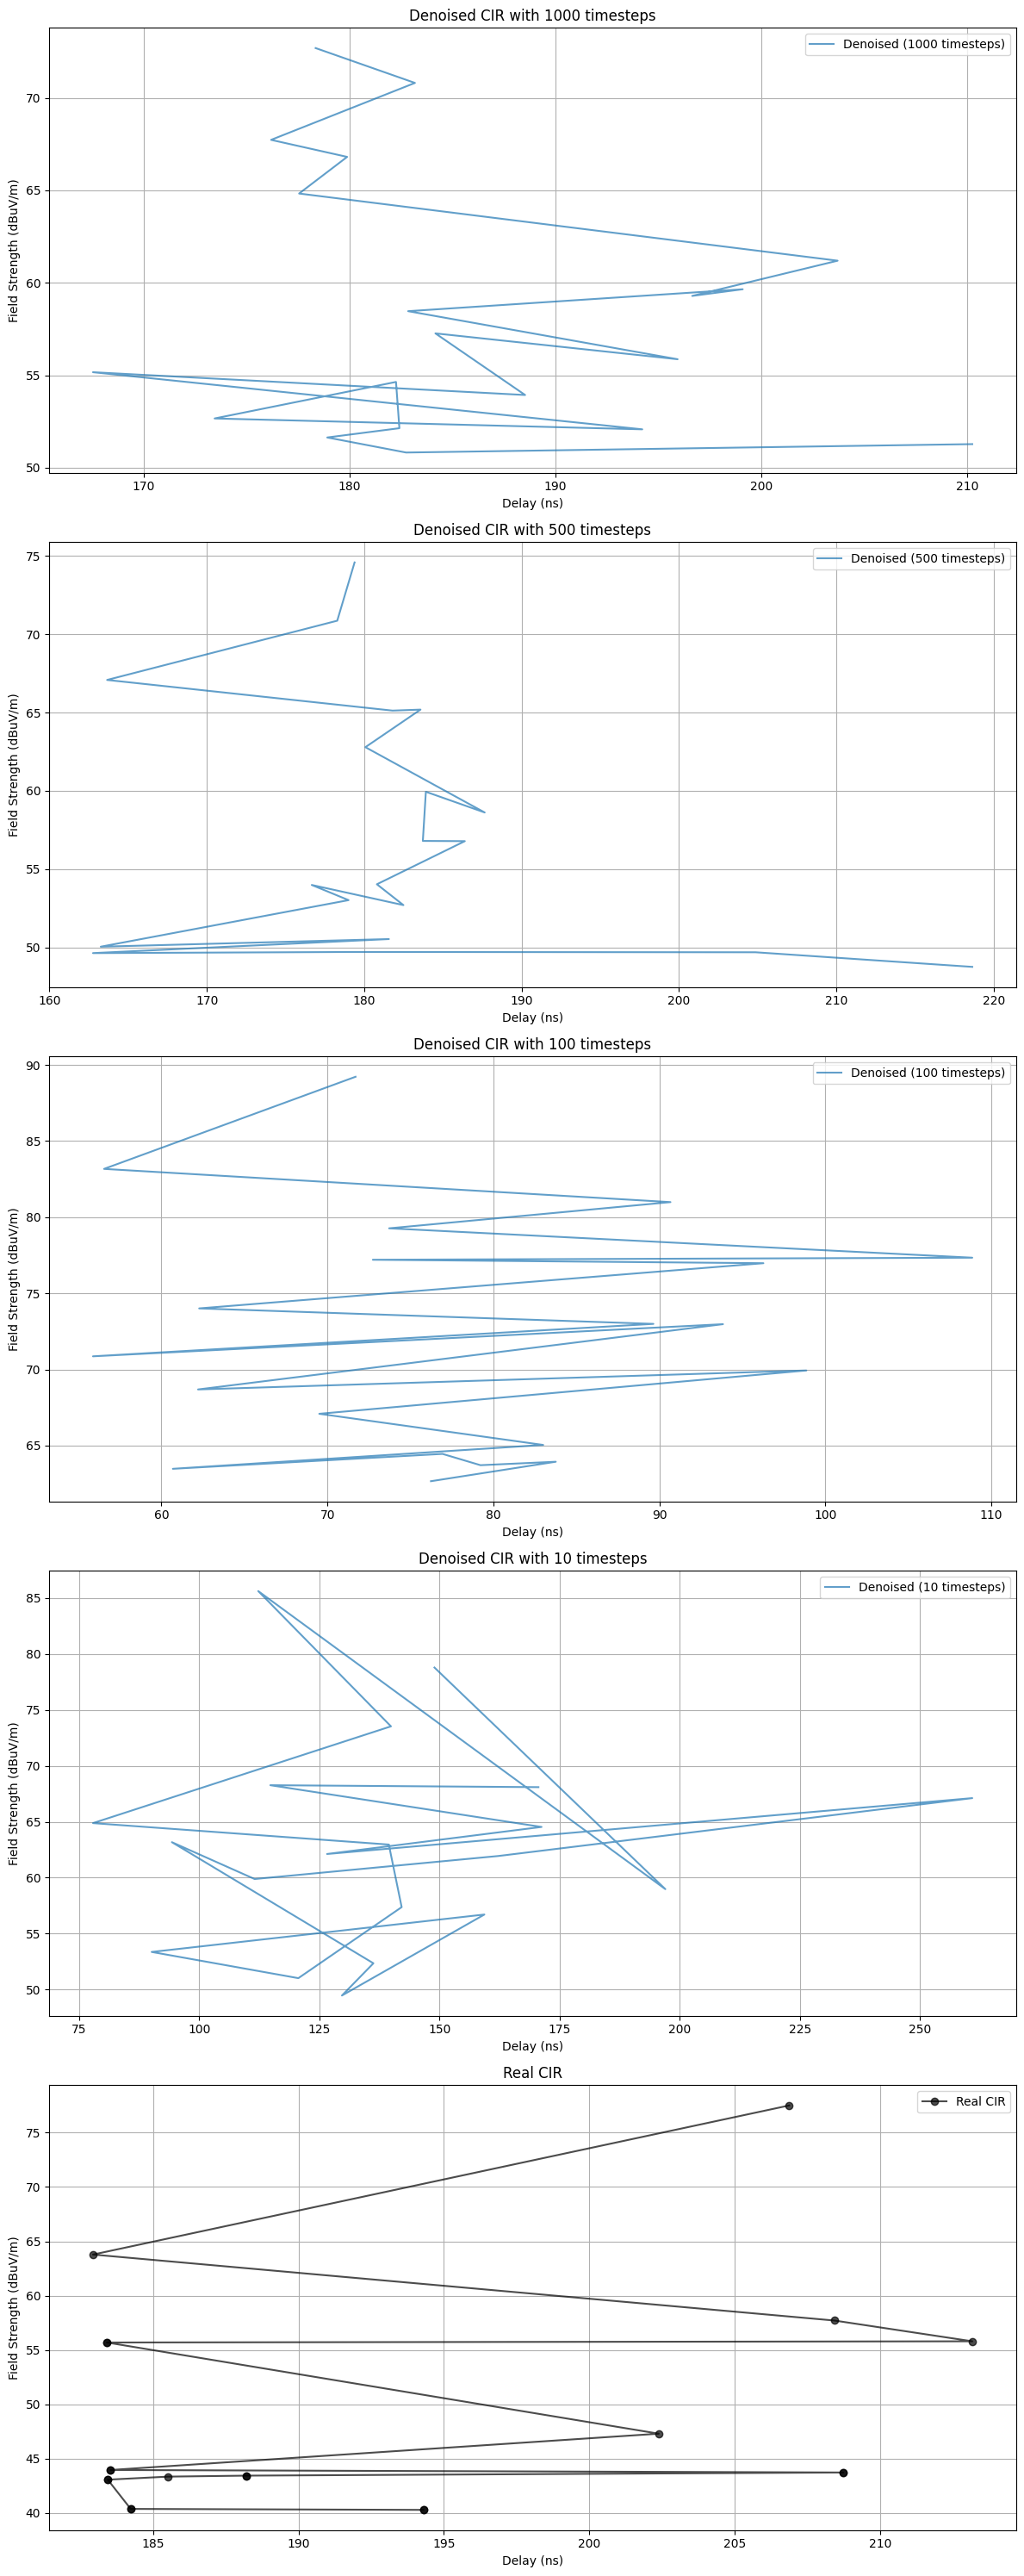

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from inference import ConditionalInference
from cir_dataset import CIRDataset

# === 加载标准化参数 ===
coord_stats = np.load("stats/coord_stats.npz")
coord_mean = coord_stats["mean"]
coord_std = coord_stats["std"]

cir_stats = np.load("stats/cir_stats.npz")
cir_mean = cir_stats["mean"]
cir_std = cir_stats["std"]

# === 你的真实坐标（单位 m）===
real_coord = np.array([-6.6500, -1.500, 1.5000])  # shape: (3,)

# 标准化后输入模型
coord_norm = (real_coord - coord_mean) / coord_std
coord_tensor = torch.tensor(coord_norm, dtype=torch.float32).unsqueeze(0)

# === 加载模型并生成 CIR ===
inference_engine = ConditionalInference(
    model_path='/tmp/pycharm_project_228/checkpoints/checkpoints_run_2_2025-03-27_23-05-16/model_epoch_1000.pth',  # 替换为你模型路径
    input_length=20,
    cond_dim=3,
    timesteps=1000
)

# 生成不同去噪阶段的 CIR（根据不同的 timesteps）
timesteps_list = [1000,500, 100, 10]
generated_cir = {}

for timesteps in timesteps_list:
    generated_cir[timesteps] = inference_engine.generate(coord_tensor, batch_size=1, x_t=timesteps)[0]
    delay = generated_cir[timesteps][:, 0] * cir_std[0] + cir_mean[0]
    amplitude = generated_cir[timesteps][:, 1] * cir_std[1] + cir_mean[1]
    phase = torch.atan2(generated_cir[timesteps][:, 3], generated_cir[timesteps][:, 2])  # sin, cos → rad
    generated_cir[timesteps] = torch.stack([delay, amplitude, phase], dim=1)

# === 可选：找真实 CIR 对比 ===
dataset = CIRDataset("data/cir_data_3.27.h5", normalize=True)

min_dist = float("inf")
real_cir = None
closest_idx = -1
threshold = 1.0  # 设置距离阈值(单位：米)

# 查找最近邻
for i in range(len(dataset)):
    coord_i, cir_i = dataset[i]
    coord_real_i = coord_i * torch.tensor(coord_std) + torch.tensor(coord_mean)
    dist = torch.norm(coord_real_i - torch.tensor(real_coord)).item()
    if dist < min_dist:
        min_dist = dist
        real_cir = cir_i
        closest_idx = i

# 添加距离检查
if min_dist > threshold:
    print(f"\n⚠️ 警告：最近样本距离{min_dist:.2f}米(超过阈值{threshold}米)，结果可能不准确")
    print(f"最近样本索引: {closest_idx}")
    print(f"最近样本坐标: {coord_real_i.tolist()}")
    print(f"目标坐标: {real_coord.tolist()}")
else:
    print(f"\n✅ 找到有效近邻，距离: {min_dist:.2f}米")

# 反标准化真实 CIR
if real_cir is not None:
    delay_r = real_cir[:, 0] * cir_std[0] + cir_mean[0]
    amp_r = real_cir[:, 1] * cir_std[1] + cir_mean[1]
    phase_r = torch.atan2(real_cir[:, 3], real_cir[:, 2])
    cir_real = torch.stack([delay_r, amp_r, phase_r], dim=1)
    print("\n📡 最接近坐标的真实 CIR:\n", cir_real)
else:
    print("\n❌ 未找到符合条件的CIR样本")
    cir_real = None

# === 绘制不同去噪阶段的 CIR 对比图 ===
fig, axs = plt.subplots(len(timesteps_list) + 1, 1, figsize=(12, 6 * (len(timesteps_list) + 1)))

# 循环绘制去噪阶段的 CIR
for idx, timesteps in enumerate(timesteps_list):
    axs[idx].plot(generated_cir[timesteps][:, 0].cpu().numpy(), 
                  generated_cir[timesteps][:, 1].cpu().numpy(),
                  label=f'Denoised ({timesteps} timesteps)', alpha=0.7)
    axs[idx].set_title(f'Denoised CIR with {timesteps} timesteps')
    axs[idx].set_xlabel('Delay (ns)')
    axs[idx].set_ylabel('Field Strength (dBuV/m)')
    axs[idx].legend()
    axs[idx].grid(True)

# 绘制真实 CIR
axs[-1].plot(cir_real[:, 0].cpu().numpy(), cir_real[:, 1].cpu().numpy(), 'o-', label='Real CIR', color='black', alpha=0.7)
axs[-1].set_title('Real CIR')
axs[-1].set_xlabel('Delay (ns)')
axs[-1].set_ylabel('Field Strength (dBuV/m)')
axs[-1].legend()
axs[-1].grid(True)

# 调整布局
plt.tight_layout()
plt.show()



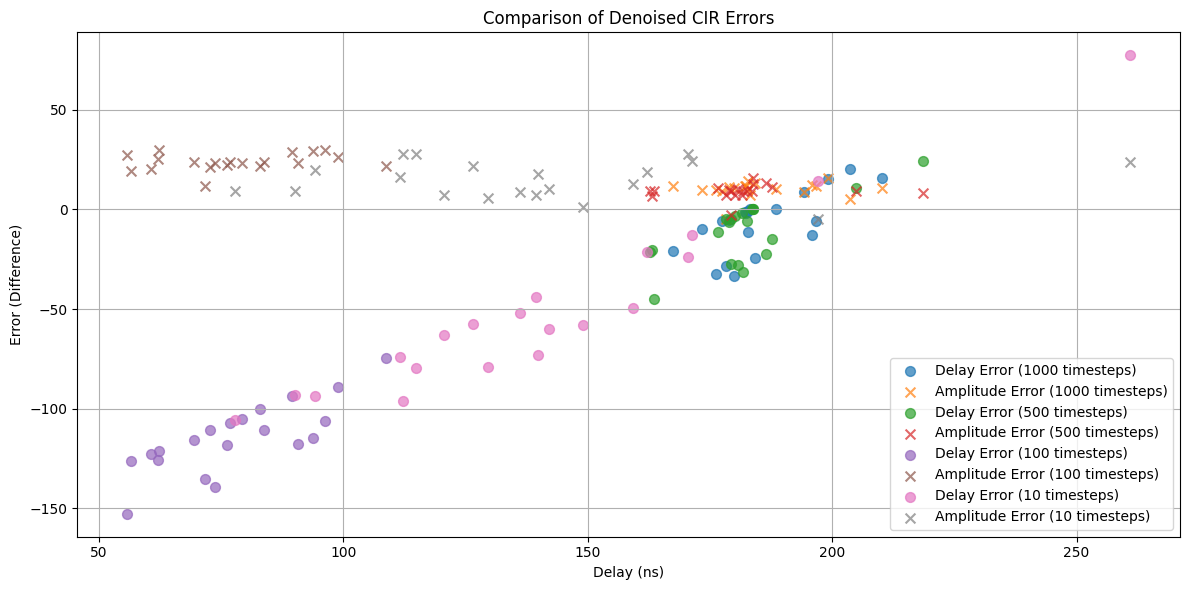

In [2]:
# === 计算并绘制误差 ===
plt.figure(figsize=(12, 6))

for timesteps in timesteps_list:
    # 计算去噪结果与真实CIR的误差
    delay_error = generated_cir[timesteps][:, 0].cpu().numpy() - cir_real[:, 0].cpu().numpy()
    amplitude_error = generated_cir[timesteps][:, 1].cpu().numpy() - cir_real[:, 1].cpu().numpy()
    
    # 只绘制误差点，不绘制线段
    plt.scatter(generated_cir[timesteps][:, 0].cpu().numpy(), delay_error, label=f'Delay Error ({timesteps} timesteps)', marker='o', s=50, alpha=0.7)
    plt.scatter(generated_cir[timesteps][:, 0].cpu().numpy(), amplitude_error, label=f'Amplitude Error ({timesteps} timesteps)', marker='x', s=50, alpha=0.7)

# 标题和标签
plt.title('Comparison of Denoised CIR Errors')
plt.xlabel('Delay (ns)')
plt.ylabel('Error (Difference)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


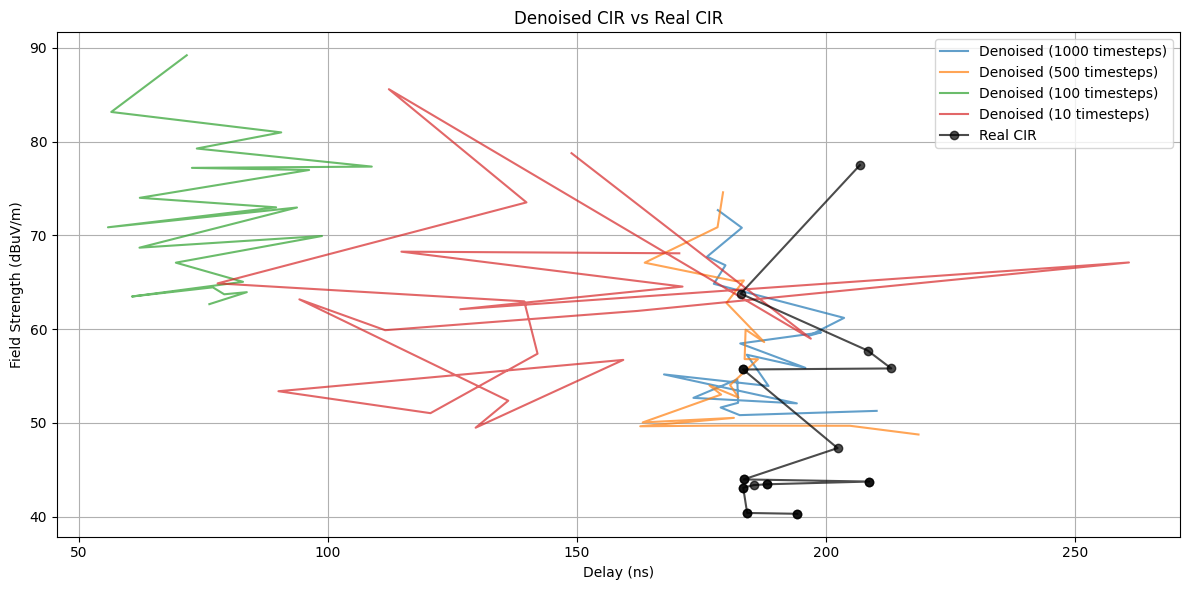

In [3]:
# === 叠加真实CIR与去噪结果 ===
plt.figure(figsize=(12, 6))

# 绘制去噪阶段的 CIR
for timesteps in timesteps_list:
    plt.plot(generated_cir[timesteps][:, 0].cpu().numpy(), 
             generated_cir[timesteps][:, 1].cpu().numpy(),
             label=f'Denoised ({timesteps} timesteps)', alpha=0.7)

# 绘制真实 CIR
plt.plot(cir_real[:, 0].cpu().numpy(), cir_real[:, 1].cpu().numpy(), 'o-', label='Real CIR', color='black', alpha=0.7)

# 标题和标签
plt.title('Denoised CIR vs Real CIR')
plt.xlabel('Delay (ns)')
plt.ylabel('Field Strength (dBuV/m)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
